<a href="https://colab.research.google.com/github/adnan119/udacity_aipwpnd_projects/blob/master/FlowerImageClassifierpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58444000 @  0x7f904dbf82a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Imports here
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from PIL import Image
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
import json
from collections import OrderedDict


In [0]:
#checking for gpu

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
/content


In [0]:
data_dir = 'gdrive/My Drive/ProjectWorks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(valid_dir, transform = val_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(val_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [0]:
with open('gdrive/My Drive/ProjectWorks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
model = models.resnet152(pretrained=True)


In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
classifier = nn.Sequential(OrderedDict([
                          #('adaptive_pool',nn.AdaptiveAvgPool2d((1,1))),
                          #('adaptive_maxpool',nn.AdaptiveMaxPool2d((1,1))),
                          #('flatten',nn.Flatten()),
                          ('batch_norm',nn.BatchNorm1d(2048,eps=1e-05, momentum=0.1, affine=True)),
                          ('Dropout',nn.Dropout(0)),
                          ('fc1', nn.Linear(2048, 520)),
                          ('activation', nn.ReLU()),
                          ('fc2', nn.Linear(520, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.fc = classifier

In [0]:
if train_on_gpu:
  model.cuda()

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
lrsheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [0]:
epochs = 30
print_every = 40
steps = 0
valid_loss_min = np.Inf
total = 0
correct = 0

# change to cuda
model.to('cuda')
validation_loss = 0
for e in range(epochs):
    training_loss = 0
    lrsheduler.step(validation_loss)
    model.train()
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*inputs.size(0)
        
        
    model.eval()
    for ii, (inputs, labels) in enumerate(validloader):

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    training_loss = training_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    _correct = (correct*100)/total
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        e, training_loss, validation_loss, _correct))
    
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        
    #to save the check-points
        model.class_to_idx = train_data.class_to_idx
        checkpoint = {'architecture': 'densenet161',
                'classifier': model.fc,
                'class_to_idx': model.class_to_idx,
                'state_dict': model.state_dict()}
        
        torch.save(checkpoint, 'model_challenge_2.pt')
        valid_loss_min = validation_loss

Epoch: 0 	Training Loss: 1.539038 	Validation Loss: 0.744360 	Accuracy: 81.907090
Validation loss decreased (inf --> 0.744360).  Saving model ...
Epoch: 1 	Training Loss: 0.881517 	Validation Loss: 0.573746 	Accuracy: 83.007335
Validation loss decreased (0.744360 --> 0.573746).  Saving model ...
Epoch: 2 	Training Loss: 0.733855 	Validation Loss: 0.539933 	Accuracy: 83.414833
Validation loss decreased (0.573746 --> 0.539933).  Saving model ...
Epoch: 3 	Training Loss: 0.679763 	Validation Loss: 0.416090 	Accuracy: 84.688264
Validation loss decreased (0.539933 --> 0.416090).  Saving model ...
Epoch: 4 	Training Loss: 0.626644 	Validation Loss: 0.420032 	Accuracy: 85.330073
Epoch: 5 	Training Loss: 0.604332 	Validation Loss: 0.432946 	Accuracy: 85.656072
Epoch: 6 	Training Loss: 0.575961 	Validation Loss: 0.385054 	Accuracy: 86.150891
Validation loss decreased (0.416090 --> 0.385054).  Saving model ...
Epoch: 7 	Training Loss: 0.536464 	Validation Loss: 0.340811 	Accuracy: 86.751222
Vali

In [0]:
for param in model.parameters():
        param.requires_grad = True

optimizer = optim.Adagrad(model.parameters(), lr=0.0003)
lrsheduler1 = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
lrsheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3)

In [0]:
epochs = 30
print_every = 40
steps = 0
valid_loss_min = validation_loss
validation_loss = 0
total = 0
correct = 0

# change to cuda
model.to('cuda')
lrsheduler = lrsheduler1
for e in range(epochs):
    training_loss = 0
    #validation_loss = 0
    lrsheduler.step(validation_loss)
    model.train()
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*inputs.size(0)
            
    model.eval()
    for ii, (inputs, labels) in enumerate(validloader):

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    training_loss = training_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    _correct = (correct*100)/total
    
    if epochs > 14 and _correct < 97:
      lrsheduler = lrsheduler2
      
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        e, training_loss, validation_loss, _correct))
    
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        
    #to save the check-points
        model.class_to_idx = train_data.class_to_idx
        checkpoint = {'architecture': 'densenet161',
                'classifier': model.fc,
                'class_to_idx': model.class_to_idx,
                'state_dict': model.state_dict()}
        
        torch.save(checkpoint, 'model_challenge_2.pt')
        valid_loss_min = validation_loss

Epoch: 0 	Training Loss: 0.361540 	Validation Loss: 0.183394 	Accuracy: 95.965770
Validation loss decreased (0.300211 --> 0.183394).  Saving model ...
Epoch: 1 	Training Loss: 0.221729 	Validation Loss: 0.162280 	Accuracy: 96.332518
Validation loss decreased (0.183394 --> 0.162280).  Saving model ...
Epoch: 2 	Training Loss: 0.187998 	Validation Loss: 0.154184 	Accuracy: 96.291769
Validation loss decreased (0.162280 --> 0.154184).  Saving model ...
Epoch: 3 	Training Loss: 0.161436 	Validation Loss: 0.138445 	Accuracy: 96.454768
Validation loss decreased (0.154184 --> 0.138445).  Saving model ...
Epoch: 4 	Training Loss: 0.150172 	Validation Loss: 0.124756 	Accuracy: 96.699267
Validation loss decreased (0.138445 --> 0.124756).  Saving model ...
Epoch: 5 	Training Loss: 0.125097 	Validation Loss: 0.132811 	Accuracy: 96.862266
Epoch: 6 	Training Loss: 0.144379 	Validation Loss: 0.134275 	Accuracy: 96.961229
Epoch: 7 	Training Loss: 0.123217 	Validation Loss: 0.137105 	Accuracy: 96.989609

In [0]:
# TODO: Do validation on the test set
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.to('cuda:0')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(testloader)

Accuracy of the network on the test images: 96 %


In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("model_challenge_2.pt")
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.fc = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

load_checkpoint()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
def process_image(image):
    img_pil = Image.open(image)
   
    image_process = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = image_process(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

img = (data_dir + '/test' + '/53/' + 'image_03672.jpg')
img = process_image(img)
print(img.shape)



torch.Size([3, 224, 224])


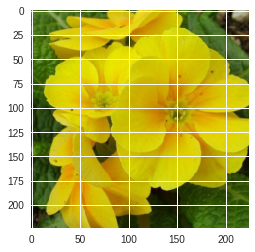

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(data_dir + '/test' + '/53/' + 'image_03672.jpg'))

In [0]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


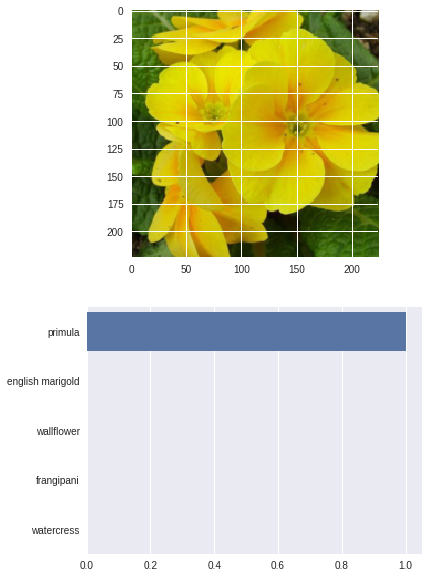

In [0]:
image_path = data_dir + '/test' + '/53/' + 'image_03672.jpg'

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[5]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()